Functions written to get results from each methos and for each replicate in an automatic manner are in the Functions section. They may be a little hard to read so do not hesitate to write me in case of questions :) 
- the SHAP values from RF models were ran later in the Comparison_methods_shapRF notebook
- sparCC
- gLASSO

# Preambule

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(randomForest)
library(qs)
library(parallel)
library(igraph)
library(ggraph)
library(inTrees)
library(RRF)
library(clustermq)
library(endoR)
library(SHAPforxgboost)
library(iBreakDown)
library(ggpubr)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomFore

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0         iBreakDown_1.3.1     SHAPforxgboost_0.1.0
 [4] endoR_0.1.0          clustermq_0.8.95.1   RRF_1.9.1           
 [7] inTrees_1.3          ggraph_2.0.4         igraph_1.2.6        
[10] qs_0.23.4            randomForest_4.6-14  data.t

In [3]:
file.sources <- list.files('../scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

# Data

In [4]:
meta <- c('dataset','Sample','age','gender','country','BMI','westernized', 'number_reads')

In [5]:
rules <- qread('../tmp/ruleExec_full.qs')
X <- qread('../tmp/X.qs')

In [6]:
# list of species/genera/family of each taxonomic feature in the dataset
related_taxa <- qread('../tmp/related_taxa_full.qs')
is_s <- str_which(names(related_taxa), pattern = '^s_')
related_taxa[is_s] <- related_taxa[is_s] %>% lapply(function(x){str_subset(x, pattern = '^s|g')})
# we add the groups so they can be counted later when counting TP and FP
related_taxa$groupa <- 'groupa'
related_taxa$groupb <- 'groupb'
related_taxa$groupc <- 'groupc'
related_taxa$groupd <- 'groupd'

In [7]:
# location of the simulated data
fnames <- list.files('/ebio/abt3_projects/temp_data/aruaud/MtgSimu50/p005_B10/', full.names = TRUE, pattern = 'simu')

In [8]:
length(fnames)

[1] 50

# Interpolation function

In [9]:
getInterpo <- function(x, lim){
    if (length(unique(x[[1]]$fp)) == 1 && unique(x[[1]]$fp) == 0){
        # if ranking is perfect!
        tmp <- data.frame(x = 0:lim, y = max(x[[1]]$tp))
    } else{
        tmp <- approx(x[[1]]$fp, x[[1]]$tp, xout = 0:lim, ties = max)
        tmp <- as.data.frame(do.call(cbind, tmp))
        # add max values to the extrapolations
        mafp <- max(tmp$x[!is.na(tmp$y)])
        tmp$y[tmp$x>mafp] <- max(tmp$y, na.rm = TRUE)
        # add the zero if na
        tmp$y[tmp$x == 0] <- ifelse(is.na(tmp$y[tmp$x == 0]), 0, tmp$y[tmp$x == 0])
    }
    
    colnames(tmp) <- c('fp', 'tp')
    return(tmp)
}

# Functions

## for curves

In [10]:
getPR <- function(thr = NULL, res, related_taxa){
    
    if (is.null(thr)) {
        tmp <- res
    } else {tmp <- subset(res, val >= thr)}
    
    if (nrow(tmp) == 0){
        return(c('tp' = NA, 'fp' = NA, 'tn' = NA, 'fn' = NA) )
    }
    nodes <- unique(tmp$var)
    
    # those that should not be but are = in pred_edges but not truth
    fp <- sum(!(nodes %in% unlist(related_taxa)))
    
    # those that should be and are
    tp <- sum(sapply(related_taxa, function(x){ifelse(sum(x %in% nodes) > 0, 1, 0)}))
    
    # those that should be but are not = in truth but not in pred_edges
    fn <- length(which(!(names(related_taxa) %in% nodes)))
    
    res <- c('tp' = tp, 'fp' = fp, 'fn' = fn) 
    return(res)
    
}

In [11]:
getWilcox <- function(X, target, group, related_taxa){
    iP <- which(target == '1')
    class(X) <- 'data.frame'
    
    # calculate values
    res <- lapply(X,
        function(v, iP){tmp <- wilcox.test(v[iP], v[-iP]);return(c('W' = tmp$statistic, 'pval' = tmp$p.value))}
                  , iP = iP)
    res <- as.data.frame(do.call(rbind, res))
    res$var <- rownames(res)
    # for the groups
    tmp <- chisq.test(group, target)
    res <- add_row(res, 'W.W' = rep(tmp$statistic, length(unique(group)))
                   ,  'pval' = rep(tmp$p.value, length(unique(group)))
                   ,  'var' = paste0('group', unique(group)) )
    res <- mutate_at(res, vars(W.W, pval), as.numeric)
    # adjust p-value and keep significant
    res$pval <- p.adjust(res$pval, method = 'BH')
    res <- subset(res, pval <= 0.05)
    # rank variables
    res <- res %>% arrange(pval, -W.W) %>% add_column('val' = seq(nrow(res), 1, -1))
    
    # get the TP vs FP curves
    thr <- sort(unique(res$val)) 
    pr <- as.data.frame(t(sapply(thr, getPR, res=res, related_taxa=related_taxa)))
    pr <- arrange(pr, tp,fp)
    pr <- group_by(pr, fp) %>% summarise_all(max)
    
    return(pr)
}

In [12]:
getGini <- function(rf, related_taxa){
    
    # calculate values
    res <- data.frame(var = rownames(rf$importance), val = rf$importance)
    colnames(res) <- c('var', 'val')
    
    # get the TP vs FP curves
    thr <- sort(unique(res$val)) 
    pr <- as.data.frame(t(sapply(thr, getPR, res=res, related_taxa=related_taxa)))
    pr <- arrange(pr, tp,fp)
    pr <- group_by(pr, fp) %>% summarise_all(max)
    
    return(pr)
}

In [13]:
getEndoRrf <- function(resampled, related_taxa, expanded_edges){
    r <- stabilitySelection(resampled, alpha_error = 5, pi_thr = 0.7)
    
    # nodes 
    r$nodes$var <- str_replace(r$nodes$var, pattern = '\\_{2}.*', replacement = '')
    colnames(r$nodes)[2] <- 'val'
    thr <- sort(unique(r$nodes$val)) 
    pr_nodes <- as.data.frame(t(sapply(thr, getPR, res=r$nodes, related_taxa=related_taxa)))
    pr_nodes <- arrange(pr_nodes, tp, fp)
    pr_nodes <- group_by(pr_nodes, fp) %>% summarise_all(max)
    
    # edges
    tmp <- unique(select(r$edges, c('x', 'y'))) 
    tmp <- asplit(as.matrix(tmp), MARGIN = 1)
    tmp <- lapply(tmp, str_replace, pattern = '\\_{2}.*', replacement = '')
    tmp <- lapply(tmp, sort)
    tmp <- sapply(tmp, function(x){paste(x, collapse = ' - ')})    
    r$edges$var <- tmp
    colnames(r$edges)[3] <- 'val'
    thr <- sort(unique(r$edges$val)) 
    pr_edges <- as.data.frame(t(sapply(thr, getPR, res=r$edges, related_taxa=expanded_edges)))
    pr_edges <- arrange(pr_edges, tp, fp)
    pr_edges <- group_by(pr_edges, fp) %>% summarise_all(max)
    
    # DE 
    nodes_de <- getPR(res=r$nodes, related_taxa=related_taxa)
    edges_de <- getPR(res=r$edges, related_taxa=expanded_edges)
    
    return(list('nodes' = pr_nodes, 'edges' = pr_edges, 'nodes_de' = nodes_de, 'edges_de' = edges_de)) # in 'edges'
}

In [14]:
getEndoRxgboost <- function(xgb_model, X, target, times = 10, n_cores = 5, n_proc = 3
                           , expanded_edges, related_taxa){
    res <- list()
    # Run .... 
    preclu <- preCluster(model = xgb_model, model_type = 'xgboost', dummy_var = 'group'
                         , discretize = TRUE, K = 3
                         , times = times, p = .75, ntree = 'all'
                         , data = X, target = target
                         , seed = 1, in_parallel = TRUE, n_cores = n_cores)
    res$preclu <- preclu
    
    options(clustermq.scheduler = "multiprocess")
    rules <- Q(model2DE_cluster
              , partition = preclu$partitions
              , export=list(data = preclu$data, target = target
                            , exec = preclu$exec, classPos = '1'
                            , prune = TRUE, maxDecay = 0.05, typeDecay = 2 
                            , filter = TRUE
                            , in_parallel = TRUE, n_cores = n_cores
                           )
              , n_jobs= n_proc
              , pkgs=c('data.table', 'parallel', 'caret', 'stringr', 'scales', 'dplyr', 'inTrees', 'endoR')
             )
    res$rules <- rules
    
    tmp <- getEndoRrf(resampled = rules, related_taxa=related_taxa, expanded_edges=expanded_edges)
    
    res$nodes <- tmp$nodes
    res$edges <- tmp$edges
    res$nodes_de <- tmp$nodes_de
    res$edges_de <- tmp$edges_de
    
    return(res)
}

In [15]:
getGiniXgboost <- function(xgb_model, related_taxa){
    feat_imp <- xgb.importance(model = xgb_model)
    colnames(feat_imp)[1:2] <- c('var', 'val')
    class(feat_imp)<- 'data.frame'
    thr <- sort(unique(feat_imp$val)) 
    pr_nodes <- as.data.frame(t(sapply(thr, getPR, res=feat_imp, related_taxa=related_taxa)))
    pr_nodes <- arrange(pr_nodes, tp, fp)
    pr_nodes <- group_by(pr_nodes, fp) %>% summarise_all(max)
    
    return(pr_nodes)
}

## for shap xgboost

In [15]:
getSingleInteractions <- function(data_long,data_int, x,y){
    data0 <- data.frame(x = rep(x, nrow(data_int))
                        , y = rep(y, nrow(data_int))
                        , shap_int = data_int[, x, y] )
    return(data0)
}

In [16]:
getAllInteractions <- function(data_long,data_int){
    colN <- as.character(unique(data_long$variable))
    res <- list()
    k <- 1
    for (i in 1:(length(colN)-1)){
        for (j in (i+1):length(colN)){
            res[[k]] <- getSingleInteractions(data_long, data_int, x = colN[i],y = colN[j])
            k <- k+1
        }
    }
    
    res <- do.call(rbind, res)
    
    return(res)
}

In [16]:
getSHAPxgboost_edges <- function(xgb_model, X_train, related_taxa,expanded_edges){
    # To prepare the long-format data:
    shap_long <- shap.prep(xgb_model = xgb_model, X_train = X_train)
    
    # nodes
    shap_nodes <- unique(select(shap_long, variable,mean_value))
    colnames(shap_nodes) <- c('var', 'val')
    thr <- sort(unique(shap_nodes$val)) 
    pr_nodes <- as.data.frame(t(sapply(thr, getPR, res=shap_nodes, related_taxa=related_taxa)))
    pr_nodes <- arrange(pr_nodes, tp, fp)
    pr_nodes <- group_by(pr_nodes, fp) %>% summarise_all(max)
    
    # edges
    shap_int <- predict(xgb_model, X_train, predinteraction = TRUE)
    shap_edges <- getAllInteractions(data_long = shap_long, data_int = shap_int)
    shap_edges <- shap_edges %>% group_by(x,y) %>% summarise(shap_mean = mean(abs(shap_int)))
    tmp <- unique(select(shap_edges, c('x', 'y'))) 
    tmp <- asplit(as.matrix(tmp), MARGIN = 1)
    tmp <- lapply(tmp, str_replace, pattern = '\\_{2}.*', replacement = '')
    tmp <- lapply(tmp, sort)
    tmp <- sapply(tmp, function(x){paste(x, collapse = ' - ')})    
    shap_edges$var <- tmp
    colnames(shap_edges)[3] <- 'val'
    thr <- sort(unique(shap_edges$val)) 
    pr_edges <- as.data.frame(t(sapply(thr, getPR, res=shap_edges, related_taxa=expanded_edges)))
    pr_edges <- arrange(pr_edges, tp, fp)
    pr_edges <- group_by(pr_edges, fp) %>% summarise_all(max)
    
    return(list('nodes' = pr_nodes, 'edges' = pr_edges))
}

## get randoms

In [20]:
getRandom <- function(K, N, B = 1000, lim = NULL, edges = FALSE){
    # Careful, by default we assume we look at nodes
    if(edges == TRUE){
        N <- (N^2-N)/2
        #K <- x$tp_edges
    } #else {K <- x$tp_nodes}
    
    if (is.null(lim)){lim<-N}
    
    urn <- c(rep(1, K), rep(0, N-K))
    rdm <- list()

    for(j in 1:B){
        set.seed(j)
        random_draw <- urn[sample(1:N)]
        tp <- cumsum(random_draw)
        fp <- 1:N - cumsum(random_draw)
        linfit <- approx(fp, tp, xout = 1:lim,ties = max)

        tmp <- as.data.frame(do.call(cbind, linfit))
        colnames(tmp)<- c('fp', 'tp')
        # add 0 and max values to the extrapolations
        mifp <- min(tmp$fp[!is.na(tmp$tp)])
        mafp <- max(tmp$fp[!is.na(tmp$tp)])
        tmp$tp[tmp$fp<mifp] <- min(tmp$tp)
        tmp$tp[tmp$fp>mafp] <- K  
        rdm[[j]] <- tmp %>% add_row(tp = 0, fp = 0)
        #rdm[[j]] <- tmp[ complete.cases(tmp), ]
      }

    rdm <- do.call(rbind, rdm)
    suppressMessages(rdm <- rdm %>% group_by(fp) %>% summarise(tp = mean(tp)))
    
    return(rdm)
}

## wrapper

In [17]:
wrapComp <- function(f, data_ori, related_taxa, times = 10
                     , lim = 100, B = 100
                     , n_cores = 5, n_proc = 5
                     , n_jobs = 100){
    
    res <- list()
    # get data 
    seedOri <- as.numeric(str_extract(f, pattern = '(?<=simu)[:digit:]+(?=\\_)'))
    res$seedOri <- seedOri
    set.seed(seedOri)
    data_ori <- data_ori[sample(1:nrow(data_ori)),]
    simu <- qread(f)
    
    # ground truth
    tn <- unique( str_replace(unlist(simu$true_edges), pattern = '\\_{2}.*', replacement = '') ) 
    related_taxa <- related_taxa[tn] 
    
    te <- lapply(simu$true_edges, str_replace, pattern = '\\_{2}.*', replacement = '') 
    te <- unique(lapply(te, sort))
    expanded_edges <- list()
    for (i in 1:length(te)){
        tmp <- related_taxa[ te[[i]] ]
        tmp <- expand.grid(tmp[[1]], tmp[[2]])  
        tmp <- asplit(tmp, MARGIN=1)
        expanded_edges[[i]] <- sapply(lapply(tmp, sort), paste, collapse = ' - ')
        names(expanded_edges)[i] <- paste(sort(te[[i]]), collapse = ' - ')
    }
    res$tp_nodes <- length(tn)
    res$tp_edges <- length(te)
    res$n_nodes <- ncol(simu$data)
    res$n_edges <- (ncol(simu$data)^2 -ncol(simu$data))/2

    # random
    res$rdm_nodes <- getRandom(K = length(tn), N = ncol(data_ori), B = B, lim = lim)
    res$rdm_edges <- getRandom(K = length(te), N = ncol(data_ori), B = B, lim = lim, edges = TRUE)
    
    # wilcox
    res$wil <- getWilcox(X = data_ori, target = simu$target, group = simu$group, related_taxa=related_taxa)
    
    # spiec-easi: too long, too bad.
    
    # gini
    res$gini <- getGini(rf = simu$rf, related_taxa=related_taxa)    
    
    # endoR
    res$endoR <- getEndoRrf(resampled = simu$resampled, related_taxa = related_taxa, expanded_edges=expanded_edges )
    
    # shap: too long?
    #res$SHARrf <- getSHAPrf(model = simu$rf, data = simu$data, target = simu$target
    #                        , classPos = '1', n_jobs = n_jobs)
    
    
    # xgboost
    y <- ifelse(simu$target == '1', 1, 0)
    set.seed(seedOri)
    res$xgb_model <- xgboost::xgboost(data = as.matrix(simu$data), label = y
                                      , objective = 'binary:logistic', nrounds = 10)

    # shap
    res$SHAPxgboost <- getSHAPxgboost(xgb_model = res$xgb_model, X_train = as.matrix(simu$data)
                                     , related_taxa = related_taxa, expanded_edges=expanded_edges)
    
    # endoR
    res$endoRxgboost <- getEndoRxgboost(xgb_model = res$xgb_model, X = simu$data, target = simu$target
                                        , times = times
                                        , n_cores = n_cores, n_proc = n_proc
                                        , related_taxa = related_taxa, expanded_edges=expanded_edges)
    
    # gini
    res$gini_xgboost <- getGiniXgboost(xgb_model = res$xgb_model, related_taxa)
    
    return(res)
    
}

# go

In [18]:
#res <- lapply(fnames, FUN = wrapComp, data_ori = X, related_taxa=related_taxa
#              , B = 100, lim = 100
#              , times = 10, n_cores = 5, n_proc = 5 )

In [19]:
res <- qread('../tmp/comparison_main.qs')

# Get the ones ran separately

In [20]:
res_sparcc <- qread('../tmp/comparison_sparcc.qs')

In [21]:
length(res)
length(res_sparcc)

[1] 50

[1] 50

In [22]:
res_glasso <- qread('../tmp/comparison_glasso.qs')

In [23]:
length(res_glasso)

[1] 50

In [24]:
res_shaprf <- qread('../tmp/comparison_shapRF.qs')

In [25]:
length(res_shaprf)

[1] 50

# format results

In [26]:
crossRes <- function(x){
    x <- do.call(rbind,x)
    x <- x %>% group_by(fp) %>% summarise_all(mean) %>% 
            left_join( x %>% group_by(fp) %>% 
            summarise_all(sd), by = 'fp', suffix = c('_avg', '_sd'))
    return(x)
}

In [27]:
lims <- as.data.frame(t(sapply(res, function(x)c('nodes' = x$n_nodes, 'edges' = x$n_edges))))
summary(lims)

     nodes           edges       
 Min.   : 9.00   Min.   : 36.00  
 1st Qu.:13.00   1st Qu.: 78.00  
 Median :14.00   Median : 91.00  
 Mean   :14.42   Mean   : 99.16  
 3rd Qu.:16.00   3rd Qu.:120.00  
 Max.   :20.00   Max.   :190.00  

## nodes

In [28]:
rdm_nodes <- lapply(res, function(x)x$rdm_nodes)
#rdm_nodes <- lapply(rdm_nodes, function(x){x$proba <- x$tp / (x$tp + x$fp);return(x)})
rdm_nodes <- crossRes(rdm_nodes)
rdm_nodes[is.na(rdm_nodes)] <- 0

In [29]:
wil_res <- lapply(res, function(x)list(x$wil, x$tp_nodes))
wil_interp <- lapply(wil_res, getInterpo, lim = ncol(X))
wil_interp <- crossRes(wil_interp)

In [30]:
gini_res <- lapply(res, function(x)list(x$gini, x$tp_nodes))
gini_interp <- lapply(gini_res, getInterpo, lim = max(lims$nodes))
gini_interp <- crossRes(gini_interp)

In [31]:
ginixgboost_res <- lapply(res, function(x)list(x$gini_xgboost, x$tp_nodes))
ginixgboost_interp <- lapply(ginixgboost_res, getInterpo, lim = max(lims$nodes))
ginixgboost_interp <- crossRes(ginixgboost_interp)

In [32]:
endorRF_nodes <- lapply(res, function(x)list(x$endoR$nodes, x$tp_nodes))
endorRF_nodes <- lapply(endorRF_nodes, getInterpo, lim = max(lims$nodes))
endorRF_nodes <- crossRes(endorRF_nodes)

In [33]:
shapXGB_nodes <- lapply(res, function(x)list(x$SHAPxgboost$nodes, x$tp_nodes))
shapXGB_nodes <- lapply(shapXGB_nodes, getInterpo, lim = max(lims$nodes))
shapXGB_nodes <- crossRes(shapXGB_nodes)

In [34]:
endorXGB_nodes <- lapply(res, function(x)list(x$endoRxgboost$nodes, x$tp_nodes))
endorXGB_nodes <- lapply(endorXGB_nodes, getInterpo, lim = max(lims$nodes))
endorXGB_nodes <- crossRes(endorXGB_nodes)

In [35]:
shapRF_nodes <- lapply(res_shaprf, function(x)list(x$nodes, x$tp_nodes))
shapRF_nodes <- lapply(shapRF_nodes, getInterpo, lim = max(lims$nodes))
shapRF_nodes <- crossRes(shapRF_nodes)

In [36]:
nodes <- rbind(wil_interp %>% add_column(method = 'Wilcoxon rank-sum and \u03C72 tests')
               , gini_interp %>% add_column(method = 'Gini importance (RF model)')
               , endorRF_nodes %>% add_column(method = 'endoR (RF model)')
               , shapRF_nodes %>% add_column(method = 'SHAP (RF model)')
               , ginixgboost_interp %>% add_column(method = 'Gini importance (xgboost model)')
               , shapXGB_nodes %>% add_column(method = 'SHAP (xgboost model)')
               , endorXGB_nodes %>% add_column(method = 'endoR (xgboost model)')
               , rdm_nodes %>% add_column(method = 'Random')
              )

In [37]:
nodes$method <- factor(nodes$method
                       , levels = c('endoR (RF model)', 'SHAP (RF model)', 'Gini importance (RF model)'
                                    ,'endoR (xgboost model)','SHAP (xgboost model)'
                                    ,'Gini importance (xgboost model)'
                       ,'Wilcoxon rank-sum and \u03C72 tests', 'Random'))

In [38]:
tps <- as.data.frame(t(sapply(res, function(x)c('nodes' = x$tp_nodes, 'edges' = x$tp_edges))))
summary(tps)

     nodes          edges     
 Min.   :8.00   Min.   :7.00  
 1st Qu.:8.00   1st Qu.:9.00  
 Median :9.00   Median :9.00  
 Mean   :8.56   Mean   :8.92  
 3rd Qu.:9.00   3rd Qu.:9.00  
 Max.   :9.00   Max.   :9.00  

## mean decision ensembles from endoR

In [39]:
endoRRF_nodes_de <- do.call(lapply(res, function(x){x$endoR$nodes_de}), what = rbind)
endoRRF_nodes_de <- as.data.frame(endoRRF_nodes_de)

In [40]:
endorXGBoost_nodes_de <- do.call(lapply(res, function(x){x$endoRxgboost$nodes_de}), what = rbind)
endorXGBoost_nodes_de <- as.data.frame(endorXGBoost_nodes_de)

In [41]:
endoRRF_edges_de <- do.call(lapply(res, function(x){x$endoR$edges_de}), what = rbind)
endoRRF_edges_de <- as.data.frame(endoRRF_edges_de)

In [42]:
endorXGBoost_edges_de <- do.call(lapply(res, function(x){x$endoRxgboost$edges_de}), what = rbind)
endorXGBoost_edges_de <- as.data.frame(endorXGBoost_edges_de)

## edges

In [43]:
rdm_edges <- lapply(res, function(x)x$rdm_edges)
rdm_edges <- crossRes(rdm_edges)

In [44]:
sparcc_edges <- lapply(res_sparcc, function(x)list(x$edges, x$tp_edges))
sparcc_edges <- lapply(sparcc_edges, getInterpo, lim = max(lims$edges))
sparcc_edges <- crossRes(sparcc_edges)

In [45]:
glasso_edges <- lapply(res_glasso, function(x)list(x$edges, x$tp_edges))
glasso_edges <- lapply(glasso_edges, getInterpo, lim = max(lims$edges))
glasso_edges <- crossRes(glasso_edges)

In [46]:
endorRF_edges <- lapply(res, function(x)list(x$endoR$edges, x$tp_edges))
endorRF_edges <- lapply(endorRF_edges, getInterpo, lim = max(lims$edges))
endorRF_edges <- crossRes(endorRF_edges)

In [47]:
endorXGB_edges <- lapply(res, function(x)list(x$endoRxgboost$edges, x$tp_edges))
endorXGB_edges <- lapply(endorXGB_edges, getInterpo, lim = max(lims$edges))
endorXGB_edges <- crossRes(endorXGB_edges)

In [48]:
shapXGB_edges <- lapply(res, function(x)list(x$SHAPxgboost$edges, x$tp_edges))
shapXGB_edges <- lapply(shapXGB_edges, getInterpo, lim = max(lims$edges))
shapXGB_edges <- crossRes(shapXGB_edges)

In [49]:
edges <- rbind(endorRF_edges %>% add_column(method = 'endoR (RF model)')
              , endorXGB_edges %>% add_column(method = 'endoR (xgboost model)')
              , shapXGB_edges %>% add_column(method = 'SHAP (xgboost model)')
              , glasso_edges %>% add_column(method = 'gLASSO')
              , sparcc_edges %>% add_column(method = 'sparCC')
              , rdm_edges %>% add_column(method = 'Random') 
              )

In [50]:
edges$method <- factor(edges$method
                       , levels = c('endoR (RF model)','endoR (xgboost model)'
                       ,'SHAP (xgboost model)', "gLASSO", 'sparCC', 'Random'))

# plots

In [51]:
cols <- c("#E69F00", "#56B4E9", "palegreen2", "#D55E00", "#0072B2", "#009E73", "#CC79A7", 'grey')

In [52]:
nodes_p <- ggplot(nodes %>% arrange(tp_avg) %>% subset(fp <= 12)
       , aes(x = fp, y = tp_avg, color = method, group = method))+

# number of tp
geom_hline(yintercept = mean(tps$nodes), color = 'lightgrey', linetype = 'dashed')+

# results
geom_ribbon(data = nodes %>% arrange(tp_avg) %>% subset(fp <= 12)
    , aes(ymin = tp_avg - tp_sd/2, ymax = tp_avg + tp_sd/2, fill = method, group = method)
    , color = NA, alpha = 0.25) +
geom_line(data = nodes %>% arrange(tp_avg) %>% subset(fp <= 12)
          , aes(x = fp, y = tp_avg, color = method, group = method), size = 1)+

# add SHAP rf on top
geom_line(size = 1)+
geom_line(data = nodes %>% subset(fp <= 12 & method == 'SHAP (xgboost model)'), size = 1
          , color = "#0072B2", linetype = 'dashed')+
#geom_line(data = nodes %>% subset(fp <= 12 & method == 'endoR (xgboost model)'), size = 1
#          , color = "#D55E00")+

# add endoR DE
geom_point(data = summarise_all(endoRRF_nodes_de, mean), aes(x = fp, y = tp, group = NULL)
           , size = 5, alpha = 1, shape = 21, color = 'black', fill = "#E69F00")+
geom_point(data = summarise_all(endorXGBoost_nodes_de, mean), aes(x = fp, y = tp, group = NULL)
          , size = 5, alpha = 1, shape = 21, color = 'black', fill = "#D55E00")+


theme_classic()+
labs(x = 'Number of FP', y = 'Number of TP', title = 'Nodes')+
scale_color_manual(values = cols, name = 'Method')+
scale_fill_manual(values = cols, name = 'Method')+
theme(legend.text = element_text(size = rel(1.2)), legend.title = element_text(size = rel(1.2)))+
xlim(c(0,5))

Warning message:
“Removed 56 row(s) containing missing values (geom_path).”
Warning message:
“Removed 56 row(s) containing missing values (geom_path).”
Warning message:
“Removed 7 row(s) containing missing values (geom_path).”


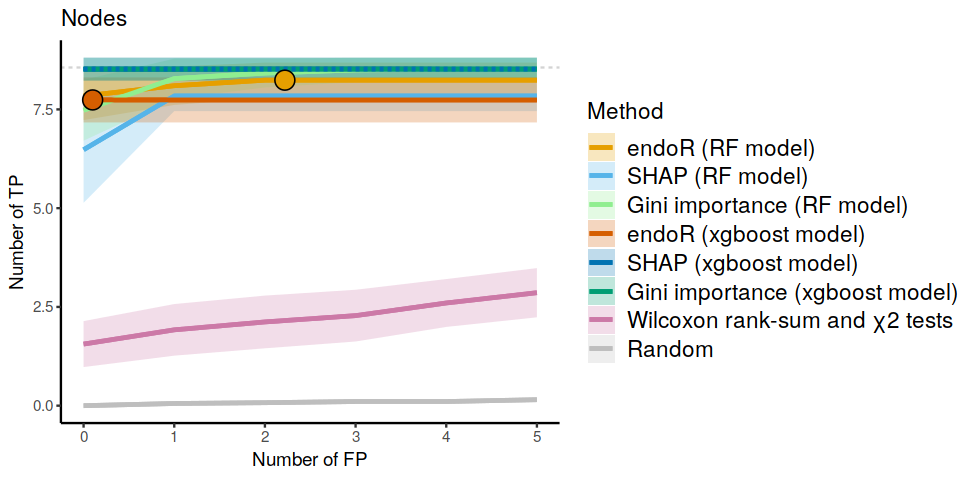

In [53]:
options(repr.plot.width=8, repr.plot.height=4)
nodes_p

## edges

In [54]:
cols <- c("#E69F00", "#D55E00", "#0072B2", "#009E73", "#CC79A7", 'grey')

edges_p <- ggplot(edges %>% arrange(tp_avg) %>% subset(fp < 50)
       , aes(x = fp, y = tp_avg, color = method, group = method))+

# number of TP
geom_hline(yintercept = mean(tps$edges), color = 'lightgrey', linetype = 'dashed')+
  
# res
geom_ribbon(aes(ymin = tp_avg - tp_sd/2, ymax = tp_avg + tp_sd/2, fill = method)
                , color = NA, alpha = 0.25) +

geom_line(size = 1.5)+
geom_line(data = edges %>% subset(fp < 50 & method == 'gLASSO'), size = 1.5
          , color = "#009E73", linetype = 'dashed')+

# add endoR DE
geom_point(data = summarise_all(endoRRF_edges_de, mean), aes(x = fp, y = tp, group = NULL)
           , size = 5, alpha = 1, shape = 21, color = 'black', fill = "#E69F00")+
geom_point(data = summarise_all(endorXGBoost_edges_de, mean), aes(x = fp, y = tp, group = NULL)
          , size = 5, alpha = 1, shape = 21, color = 'black', fill = "#D55E00")+


theme_classic()+
labs(x = 'Number of FP', y = 'Number of TP', title = 'Edges')+
scale_color_manual(values = cols, name = 'Method')+
scale_fill_manual(values = cols, name = 'Method')+
theme(legend.text = element_text(size = rel(1.2)), legend.title = element_text(size = rel(1.2)))+
xlim(c(0,20))

Warning message:
“Removed 174 row(s) containing missing values (geom_path).”
Warning message:
“Removed 29 row(s) containing missing values (geom_path).”


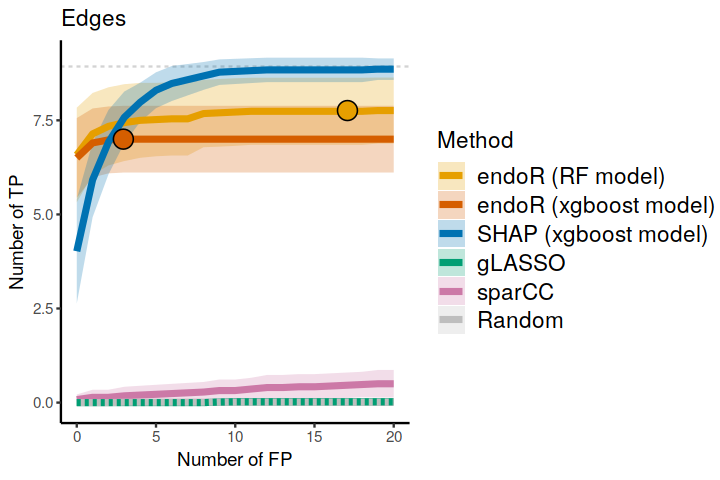

In [55]:
options(repr.plot.width=6, repr.plot.height=4)
edges_p

# check the XGBoost accuracy

In [51]:
# could use confusionMatrix()
getKappa <- function(x){
    p0 <- (x[1,1] + x[2,2]) / sum(x)
    py <- (x[1,1] + x[1,2])*(x[1,1] + x[2,1]) / sum(x)^2
    pn <- (x[2,1] + x[2,2])*(x[1,2] + x[2,2]) / sum(x)^2
    pe <- py+pn
    
    k <- 1 - (1-p0)/(1-pe)
    return(k)
}

In [96]:
getXGBoostKappas <- function(i, fnames, res, seeds_f){
    print(i)
    simu <- qread(fnames[seeds_f == res[[i]]$seedOri])
    
    set.seed(res[[i]]$seedOri)
    trainIx <- createDataPartition(y = simu$target, times = 10, p = .7, list = TRUE)
    xgb_kappas <- sapply(trainIx, getSingleXGBkappa, model = res[[i]]$xgb_model
                         , data = as.matrix(simu$data), target = ifelse(simu$target == '1', 1, 0))
    
    return(c('xgb_avg'= mean(xgb_kappas), 'xgb_sd'= sd(xgb_kappas)
             , 'rf_avg' = simu$gamma_all[as.character(simu$gamma), 'meanK']
             , 'rf_sd' = simu$gamma_all[as.character(simu$gamma), 'sdK']
            ))
}

In [97]:
getSingleXGBkappa <- function(ix, model, data, target){
    xgb_pred <- predict(object = model, data[ix, ])
    xgb_pred <- as.matrix(table(round(xgb_pred, digits = 0), target[ix]))
    return(getKappa(xgb_pred))
}

In [98]:
seeds_f <- str_extract(fnames, pattern = '[:digit:]*(?=\\_p0)') %>% as.numeric

In [99]:
fnames <- list.files('/ebio/abt3_projects/temp_data/aruaud/MtgSimu50/p005_B10/', full.names = TRUE, pattern = 'simu')

In [101]:
kappas <- lapply(1:length(res), getXGBoostKappas, fnames = fnames, res = res, seeds_f=seeds_f)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50


In [102]:
kappas <- do.call(rbind, kappas)

In [103]:
kappas %>% summary

    xgb_avg           xgb_sd             rf_avg           rf_sd        
 Min.   :0.9436   Min.   :0.002304   Min.   :0.8553   Min.   :0.01177  
 1st Qu.:0.9643   1st Qu.:0.003192   1st Qu.:0.8897   1st Qu.:0.01885  
 Median :0.9718   Median :0.003610   Median :0.9041   Median :0.02212  
 Mean   :0.9702   Mean   :0.003711   Mean   :0.9059   Mean   :0.03048  
 3rd Qu.:0.9761   3rd Qu.:0.004366   3rd Qu.:0.9261   3rd Qu.:0.03430  
 Max.   :0.9863   Max.   :0.005762   Max.   :0.9431   Max.   :0.13051  